# Initialise

In [1]:
#! /usr/bin/env python

'''
Trains 7D QuaLiKiz-NN with a single output (efiTG)
'''

from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras import backend as K
import pandas
import numpy
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from copy import deepcopy

# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])

# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("../unstable_training_gen2_7D_nions0_flat_filter7.h5")
target_df = store['efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']


Using TensorFlow backend.


In [2]:
# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a (deep) copy of joined_dataFrame for late use
joined_dataFrame_original = deepcopy(joined_dataFrame)

# Normalize data by standard deviation and mean-centering the data
joined_dataFrame['efeETG_GB'] = joined_dataFrame['efeETG_GB'] / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean())/joined_dataFrame['efeETG_GB'].std()

joined_dataFrame['Ati'] = joined_dataFrame['Ati'] / joined_dataFrame['Ati'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean())/joined_dataFrame['Ati'].std()

joined_dataFrame['Ate'] = joined_dataFrame['Ate'] / joined_dataFrame['Ate'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean())/joined_dataFrame['Ate'].std()

joined_dataFrame['An'] = joined_dataFrame['An'] / joined_dataFrame['An'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean())/joined_dataFrame['An'].std()

joined_dataFrame['qx'] = joined_dataFrame['qx'] / joined_dataFrame['qx'].std()
joined_dataFrame['qx'] = (joined_dataFrame['qx'] - joined_dataFrame['qx'].mean())/joined_dataFrame['qx'].std()

joined_dataFrame['smag'] = joined_dataFrame['smag'] / joined_dataFrame['smag'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean())/joined_dataFrame['smag'].std()

joined_dataFrame['x'] = joined_dataFrame['x'] / joined_dataFrame['x'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean())/joined_dataFrame['x'].std()

joined_dataFrame['Ti_Te'] = joined_dataFrame['Ti_Te'] / joined_dataFrame['Ti_Te'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean())/joined_dataFrame['Ti_Te'].std()



# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Creates a pandas dataframe for the inputs
shuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df.iloc[:int(
    numpy.round(len(shuffled_clean_input_df)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df.iloc[int(
    numpy.round(len(shuffled_clean_input_df)*0.9)):]

# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()

In [3]:
print(x_test)

               Ati       Ate        An        qx      smag         x     Ti_Te
11868127 -0.913761 -1.159999 -0.634902 -0.674946 -0.314697  1.243397 -0.555741
21581863 -0.404145 -1.159999 -0.339667 -0.556750 -0.314697  0.719553  1.665897
11532763 -0.913761 -1.407881 -0.044432 -0.674946  0.203593  0.719553 -0.066980
28937335 -0.149337  1.814580  0.546038 -0.674946  0.203593 -1.375825 -1.296286
46895539  0.869895 -0.416355 -1.225372  0.152425 -1.264894 -1.375825 -0.555741
36644197  0.360279 -0.912118  1.136507 -0.083967 -1.264894 -1.375825  1.665897
3887791  -1.848058 -0.168473 -0.044432  0.152425 -1.264894  1.243397 -0.555741
14417965 -0.913761  1.814580  0.546038 -0.793142 -1.264894  0.300477  1.665897
48269893  0.869895  1.814580  0.250803 -0.083967 -1.264894 -0.118598 -1.296286
41433577  0.615087 -0.912118  0.546038 -0.793142  0.462737 -0.956749  0.421780
38308129  0.360279  1.814580 -4.177720 -0.793142 -0.055552 -0.537673 -0.926014
28141789 -0.149337 -0.168473  0.546038 -0.320359  0.

In [4]:
print(type(x_test))

<class 'pandas.core.frame.DataFrame'>


In [5]:
x_test_np_array = x_test.values
print(type(x_test_np_array))

<class 'numpy.ndarray'>


In [6]:
'''
x_test_np_array_normalized = x_test_normalized.values
print(type(x_test_np_array_normalized))
'''

'\nx_test_np_array_normalized = x_test_normalized.values\nprint(type(x_test_np_array_normalized))\n'

In [7]:
print(y_test)

11868127   -0.773853
21581863   -0.146032
11532763   -0.761631
28937335    2.494760
46895539   -0.618119
36644197   -0.804964
3887791    -0.374069
14417965    1.265802
48269893    1.032907
41433577   -1.087209
38308129   -0.639286
28141789    0.608951
7620889    -0.663085
37412083    0.544193
28454521    1.501138
8612401    -0.689715
22022425    0.561585
13883713   -0.172356
33553057    1.405426
31332583   -0.599968
8393479     0.773016
37602241   -0.504610
31308553   -0.320442
42904681   -0.596651
18517873   -1.082976
53054563   -0.033581
51757501   -0.997909
27205951    0.303178
16797505    0.164595
38507863    2.852317
              ...   
41335369   -0.520813
33378583   -0.479042
37424167    0.480078
57995311    1.049323
43200529   -0.070460
23538667   -0.037414
18109555   -0.192866
16841095   -1.063564
19089637    0.457415
50984929   -0.843525
12644341    0.659993
7812289    -0.073437
13118245   -1.028000
21639355   -0.923083
29016973    1.760622
7177435    -1.083817
33315883    1

In [8]:
y_test_np_array = y_test.values
print(y_test_np_array)

[-0.77385256 -0.14603191 -0.76163058 ... -1.06287475  0.59713221
  0.18273425]


In [9]:
'''
y_test_np_array_normalized = y_test_normalized.values
print(y_test_np_array_normalized)
'''

'\ny_test_np_array_normalized = y_test_normalized.values\nprint(y_test_np_array_normalized)\n'

In [10]:
print(type(y_test_np_array))

<class 'numpy.ndarray'>


In [11]:
'''
print(type(y_test_np_array_normalized))
'''

'\nprint(type(y_test_np_array_normalized))\n'

# Load Model

In [12]:
from keras.models import load_model
#new_model = load_model('../IPP-Neural-Networks/Saved-Networks/2018-05-31_7D_Run0050b.h5', custom_objects={'rmse': rmse})
new_model = load_model('../Saved-Networks/2018-07-12_7D_Run0050c.h5', custom_objects={'rmse': rmse})

In [13]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


In [14]:
new_model.get_weights()

[array([[-3.16479430e-02,  5.04655689e-02, -2.61113327e-02,
          3.08822487e-02,  1.21066696e-03,  5.02853207e-02,
         -1.20531628e-03,  1.03293164e-02, -4.16055974e-03,
         -3.05728503e-02,  2.31332518e-02, -2.21788231e-02,
         -7.00914301e-04,  6.45024190e-03, -2.03070249e-02,
         -4.19061631e-03, -2.30814777e-02,  6.76990859e-03,
         -1.88332908e-02,  2.49650516e-02, -1.20236631e-02,
          2.44641136e-02, -2.22857147e-02, -8.23354628e-03,
         -5.73485456e-02, -6.08279929e-03,  4.22564195e-03,
         -1.38336932e-02, -4.21615019e-02,  6.19490817e-03],
        [ 5.62631607e-01,  6.37362540e-01,  8.38864863e-01,
          4.06871408e-01, -1.04685258e-02, -3.59189391e-01,
         -1.14711237e+00, -1.77789703e-01,  4.42449391e-01,
         -1.45964742e-01, -2.08335742e-01,  3.65817159e-01,
         -4.76360828e-01,  7.27037847e-01, -7.14686692e-01,
         -9.18490529e-01, -2.46518195e-01,  1.15024495e+00,
          9.74493921e-01,  1.32277155e+

In [15]:
new_model.optimizer

# Predictions

In [16]:
'''
predictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))
'''

'\npredictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)\nprint(type(predictions))\n\npredictions = predictions.flatten()\nprint(predictions.shape)\nprint(type(predictions))\n'

In [17]:
'''
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(predictions)
plt.title('QuaLiKiz-NN Predictions Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nplt.hist(predictions)\nplt.title('QuaLiKiz-NN Predictions Histogram')\nplt.xlabel('Values')\nplt.ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/NN_Predictions.png', dpi = 100)\nplt.show()\n"

# Plotting

##### Karel had two populations (thesis figure 5.1) at x=0 and y=0 where weird artifacts showed up. I didn't get anything like that (zoomed in around origin).

In [18]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=1000, norm=LogNorm())
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim([0, 100])
plt.xlim([0, 100])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/Zoomed-In.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions, bins=1000, norm=LogNorm())\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim([0, 100])\nplt.xlim([0, 100])\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/Zoomed-In.png', dpi = 100)\nplt.show()\n"

In [19]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=100, cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions, bins=100, cmin=5)\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (non-log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim(0)\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)\nplt.show()\n"

In [20]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=350, cmin=6)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim([0, 0.3])
plt.xlim([0, 0.3])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_ZoomedIn.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions, bins=350, cmin=6)\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (non-log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim([0, 0.3])\nplt.xlim([0, 0.3])\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_ZoomedIn.png', dpi = 100)\nplt.show()\n"

# Plotting non-normalized values

In [21]:
'''
print(type(predictions))
print(predictions.max(), predictions.min())
'''

'\nprint(type(predictions))\nprint(predictions.max(), predictions.min())\n'

In [22]:
'''
print(predictions.shape)
'''

'\nprint(predictions.shape)\n'

In [23]:
'''
predictions_nonNormalized = predictions*116.856499
print(predictions_nonNormalized)
'''

'\npredictions_nonNormalized = predictions*116.856499\nprint(predictions_nonNormalized)\n'

In [24]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=1000, norm=LogNorm())
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins1000.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions_nonNormalized, bins=1000, norm=LogNorm())\nplt.title('QuaLiKiz vs Neural Network (log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim(0)\nplt.xlim(0)\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins1000.png', dpi = 100)\nplt.show()\n"

In [25]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim(0)\nplt.xlim(0)\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)\nplt.show()\n"

In [26]:
joined_dataFrame.head()

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
978721,-1.062802,-1.848058,-1.903644,-0.634902,-0.793142,-0.055552,1.243397,1.665897
981745,-1.099909,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.243397,1.665897
981787,-1.036617,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.767242,1.665897
985063,-1.115442,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,0.719553,1.665897
985105,-1.046617,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,1.243397,1.665897


In [27]:
joined_dataFrame.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05,6.388800e+05
mean,1.865620e-14,-6.174258e-12,1.616550e-12,-2.162388e-12,1.051146e-12,-4.408851e-13,1.827640e-12,-3.604733e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.136272e+00,-1.848058e+00,-2.151526e+00,-4.177720e+00,-8.735150e-01,-1.264894e+00,-1.375825e+00,-1.666559e+00
25%,-8.023415e-01,-6.589535e-01,-6.642361e-01,-6.349019e-01,-6.749461e-01,-3.146967e-01,-9.567490e-01,-9.260135e-01
50%,-3.018490e-01,-1.493374e-01,-1.684729e-01,-4.443218e-02,-4.385544e-01,-5.555202e-02,-1.185980e-01,-6.698017e-02
75%,5.578201e-01,6.150866e-01,4.925446e-01,5.460375e-01,1.524246e-01,4.627374e-01,7.195530e-01,4.217800e-01
max,3.965472e+00,2.908359e+00,1.814580e+00,2.317447e+00,2.516341e+00,3.918000e+00,1.767242e+00,1.665897e+00


In [28]:
joined_dataFrame.to_csv('./out.csv', encoding='utf-8')

In [29]:
'''
# plt.xkcd()
plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)
plt.show()
'''

"\n# plt.xkcd()\nplt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim(0)\nplt.xlim(0)\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)\nplt.show()\n"

In [30]:
'''
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()
'''

"\nfrom matplotlib.colors import LogNorm\nimport matplotlib.pyplot as plt\n\nplt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, cmin=5)\nplt.plot( [0,1],[0,1] )\nplt.title('QuaLiKiz vs Neural Network (non-log scale)')\nplt.xlabel('QuaLiKiz')\nplt.ylabel('Neural Network')\nplt.ylim(0)\ncbar = plt.colorbar()\ncbar.ax.set_ylabel('Counts')\nplt.savefig('./2018-07-12_Run0050c_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)\nplt.show()\n"

In [31]:
'''
h = plt.hist2d(y_test_np_array, predictions_nonNormalized,bins = 100)
'''

'\nh = plt.hist2d(y_test_np_array, predictions_nonNormalized,bins = 100)\n'

In [32]:
'''
print(h)
'''

'\nprint(h)\n'

In [33]:
'''
print(h[0])
'''

'\nprint(h[0])\n'

In [34]:
'''
sigmas = []
Qualikiz = y_test_np_array
for i in range(len(h[0])):
    sigmas.append(numpy.std(h[0][i] / numpy.max(h[0][i])))
'''

'\nsigmas = []\nQualikiz = y_test_np_array\nfor i in range(len(h[0])):\n    sigmas.append(numpy.std(h[0][i] / numpy.max(h[0][i])))\n'

In [35]:
'''
plt.plot((numpy.array(h[1][1:]) + numpy.array(h[1][:-1]))/2.,sigmas)
'''

'\nplt.plot((numpy.array(h[1][1:]) + numpy.array(h[1][:-1]))/2.,sigmas)\n'

In [36]:
'''
for i in range(10):
    plt.plot((h[1][1:] + h[1][:-1])/2., h[0][i]/numpy.max(h[0][i]) )
'''

'\nfor i in range(10):\n    plt.plot((h[1][1:] + h[1][:-1])/2., h[0][i]/numpy.max(h[0][i]) )\n'

In [37]:
'''
plt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.5)
'''

"\nplt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.5)\n"

In [38]:
'''
plt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.1)
#plt.savefig('',dpi = 600)
'''

"\nplt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.1)\n#plt.savefig('',dpi = 600)\n"

# Data Slicer

### Looking at Data Frames

In [39]:
print(joined_dataFrame)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

In [40]:
joined_dataFrame.Ate.describe

<bound method NDFrame.describe of 978721     -1.903644
981745     -1.903644
981787     -1.903644
985063     -1.903644
985105     -1.903644
985147     -1.903644
988423     -1.903644
988465     -1.903644
988501     -1.903644
988507     -1.903644
991825     -1.903644
991867     -1.903644
995185     -1.903644
995221     -1.903644
995227     -1.903644
998581     -1.903644
998587     -1.903644
1012027    -1.903644
1012321    -1.903644
1012363    -1.903644
1015387    -1.903644
1015597    -1.903644
1015639    -1.903644
1015681    -1.903644
1015717    -1.903644
1015723    -1.903644
1018705    -1.903644
1018747    -1.903644
1018957    -1.903644
1018999    -1.903644
              ...   
58060165    1.814580
58060189    1.814580
58060195    1.814580
58060207    1.814580
58060231    1.814580
58060237    1.814580
58060243    1.814580
58060267    1.814580
58060273    1.814580
58060279    1.814580
58060285    1.814580
58060321    1.814580
58060333    1.814580
58060369    1.814580
58060543    1.814580


### Masks

#### Ate

In [41]:
Ate_mask1 = joined_dataFrame.Ate == 2
Ate_mask2 = joined_dataFrame.Ate == 2.75
Ate_mask3 = joined_dataFrame.Ate == 3.5
Ate_mask4 = joined_dataFrame.Ate == 4.25
Ate_mask5 = joined_dataFrame.Ate == 5
Ate_mask6 = joined_dataFrame.Ate == 5.75
Ate_mask7 = joined_dataFrame.Ate == 6.5
Ate_mask8 = joined_dataFrame.Ate == 7.25
Ate_mask9 = joined_dataFrame.Ate == 8
Ate_mask10 = joined_dataFrame.Ate == 10
Ate_mask11 = joined_dataFrame.Ate == 14

Ate_anti_mask1 = joined_dataFrame.Ate != 2
Ate_anti_mask2 = joined_dataFrame.Ate != 2.75
Ate_anti_mask3 = joined_dataFrame.Ate != 3.5
Ate_anti_mask4 = joined_dataFrame.Ate != 4.25
Ate_anti_mask5 = joined_dataFrame.Ate != 5
Ate_anti_mask6 = joined_dataFrame.Ate != 5.75
Ate_anti_mask7 = joined_dataFrame.Ate != 6.5
Ate_anti_mask8 = joined_dataFrame.Ate != 7.25
Ate_anti_mask9 = joined_dataFrame.Ate != 8
Ate_anti_mask10 = joined_dataFrame.Ate != 10
Ate_anti_mask11 = joined_dataFrame.Ate != 14



'''
# Ate has MANY values for
2.75
3.5
4.25
5
5.75
6.5
7.25
8

# and VERY FEW values for
10
2
'''



newDF = joined_dataFrame[Ate_anti_mask1 & Ate_anti_mask2 & Ate_anti_mask3 & Ate_anti_mask4 & Ate_anti_mask5 &
                        Ate_anti_mask6 & Ate_anti_mask7]
print(newDF)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

#### An

In [42]:
An_mask1 = joined_dataFrame.An == -5
An_mask2 = joined_dataFrame.An == -3
An_mask3 = joined_dataFrame.An == -1
An_mask4 = numpy.array(joined_dataFrame.An <= 1.1e-14) * numpy.array(joined_dataFrame.An >= 9E-15)
An_mask5 = joined_dataFrame.An == 0.5
An_mask6 = joined_dataFrame.An == 1.0
An_mask7 = joined_dataFrame.An == 1.5
An_mask8 = joined_dataFrame.An == 2.0
An_mask9 = joined_dataFrame.An == 2.5
An_mask10 = joined_dataFrame.An == 3.0
An_mask11 = joined_dataFrame.An == 4.0
An_mask12 = joined_dataFrame.An == 6.0

An_anti_mask1 = joined_dataFrame.An != -5
An_anti_mask2 = joined_dataFrame.An != -3
An_anti_mask3 = joined_dataFrame.An != -1
An_anti_mask4 = joined_dataFrame.An != 9.9999998245167E-15
An_anti_mask5 = joined_dataFrame.An != 0.5
An_anti_mask6 = joined_dataFrame.An != 1.0
An_anti_mask7 = joined_dataFrame.An != 1.5
An_anti_mask8 = joined_dataFrame.An != 2.0
An_anti_mask9 = joined_dataFrame.An != 2.5
An_anti_mask10 = joined_dataFrame.An != 3.0
An_anti_mask11 = joined_dataFrame.An != 4.0
An_anti_mask12 = joined_dataFrame.An != 6.0


newDF = joined_dataFrame[An_anti_mask1 & An_anti_mask2 & An_anti_mask3 & An_anti_mask4 & An_anti_mask5 &
                        An_anti_mask6 & An_anti_mask7 & An_anti_mask8 & An_anti_mask9 & An_anti_mask10 &
                        An_anti_mask11 & An_anti_mask12]

print(newDF)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

#### Ati

In [43]:
print(An_mask4.any() == True)

False


In [44]:
Ati_mask1 = numpy.array(joined_dataFrame.Ati <= 1.1e-14) * numpy.array(joined_dataFrame.Ati >= 9E-15)
Ati_mask2 = joined_dataFrame.Ati == 2
Ati_mask3 = joined_dataFrame.Ati == 2.75
Ati_mask4 = joined_dataFrame.Ati == 3.5
Ati_mask5 = joined_dataFrame.Ati == 4.25
Ati_mask6 = joined_dataFrame.Ati == 5
Ati_mask7 = joined_dataFrame.Ati == 5.75
Ati_mask8 = joined_dataFrame.Ati == 6.5
Ati_mask9 = joined_dataFrame.Ati == 7.25
Ati_mask10 = joined_dataFrame.Ati == 8
Ati_mask11 = joined_dataFrame.Ati == 10
Ati_mask12 = joined_dataFrame.Ati == 14

newDF = joined_dataFrame[Ati_mask1]

print(newDF)

Empty DataFrame
Columns: [efeETG_GB, Ati, Ate, An, qx, smag, x, Ti_Te]
Index: []


#### qx

In [45]:
qx_mask0 = numpy.array(joined_dataFrame.qx <= 0.67) * numpy.array(joined_dataFrame.qx >= 0.65)  #0.660000026226043
qx_mask1 = joined_dataFrame.qx == 1.0
qx_mask2 = joined_dataFrame.qx == 1.5
qx_mask3 = joined_dataFrame.qx == 2.0
qx_mask4 = joined_dataFrame.qx == 2.5
qx_mask5 = joined_dataFrame.qx == 3.0
qx_mask6 = joined_dataFrame.qx == 4.0
qx_mask7 = joined_dataFrame.qx == 5.0
qx_mask8 = joined_dataFrame.qx == 10.00
qx_mask9 = joined_dataFrame.qx == 15.00

qx_anti_mask0 = joined_dataFrame.qx != 0.660000026226043    # NOT WORKING!!!!
qx_anti_mask1 = joined_dataFrame.qx != 1.0
qx_anti_mask2 = joined_dataFrame.qx != 1.5
qx_anti_mask3 = joined_dataFrame.qx != 2.0
qx_anti_mask4 = joined_dataFrame.qx != 2.5
qx_anti_mask5 = joined_dataFrame.qx != 3.0
qx_anti_mask6 = joined_dataFrame.qx != 4.0
qx_anti_mask7 = joined_dataFrame.qx != 5.0
qx_anti_mask8 = joined_dataFrame.qx != 10.00
qx_anti_mask9 = joined_dataFrame.qx != 15.00


newDF = joined_dataFrame[qx_anti_mask1 & qx_anti_mask2 & qx_anti_mask3 & qx_anti_mask4 & qx_anti_mask5 &
                        qx_anti_mask6 & qx_anti_mask7 & qx_anti_mask8 & qx_anti_mask9 & qx_anti_mask0]

print(newDF)
# print(qx_anti_mask0)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

#### smag

In [46]:
smag_mask1 = joined_dataFrame.smag == -1.0
smag_mask2 = numpy.array(joined_dataFrame.smag <= 0.11) * numpy.array(joined_dataFrame.smag >= 0.09)   # 0.100000001490116
smag_mask3 = numpy.array(joined_dataFrame.smag <= 0.41) * numpy.array(joined_dataFrame.smag >= 0.39)   # 0.400000005960464
smag_mask4 = numpy.array(joined_dataFrame.smag <= 0.71) * numpy.array(joined_dataFrame.smag >= 0.68)   # 0.699999988079071
smag_mask5 = joined_dataFrame.smag == 1
smag_mask6 = joined_dataFrame.smag == 1.5
smag_mask7 = joined_dataFrame.smag == 2.0
smag_mask8 = joined_dataFrame.smag == 2.75
smag_mask9 = joined_dataFrame.smag == 3.5
smag_mask10 = joined_dataFrame.smag == 5.0

smag_anti_mask1 = joined_dataFrame.smag != -1.0
smag_anti_mask2 = joined_dataFrame.smag != 0.100000001490116    # NOT WORKING!!!!!
smag_anti_mask3 = joined_dataFrame.smag != 0.400000005960464    # NOT WORKING!!!!!
smag_anti_mask4 = joined_dataFrame.smag != 0.699999988079071    # NOT WORKING!!!!!
smag_anti_mask5 = joined_dataFrame.smag != 1
smag_anti_mask6 = joined_dataFrame.smag != 1.5
smag_anti_mask7 = joined_dataFrame.smag != 2.0
smag_anti_mask8 = joined_dataFrame.smag != 2.75
smag_anti_mask9 = joined_dataFrame.smag != 3.5
smag_anti_mask10 = joined_dataFrame.smag != 5.0


newDF = joined_dataFrame[smag_anti_mask1 & smag_anti_mask2 & smag_anti_mask3 & smag_anti_mask4 &
                        smag_anti_mask5 & smag_anti_mask6 & smag_anti_mask7 & smag_anti_mask8 & smag_anti_mask9 &
                        smag_anti_mask10]

print(newDF)

# joined_dataFrame.to_csv('./joined_dataFrame.csv', encoding='utf-8')
newDF.to_csv('./out_smag.csv', encoding='utf-8')

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

#### x

In [47]:
x_mask1 = numpy.array(joined_dataFrame.x <= 0.10) * numpy.array(joined_dataFrame.x >= 0.08)   # 0.09
x_mask2 = numpy.array(joined_dataFrame.x <= 0.22) * numpy.array(joined_dataFrame.x >= 0.20)   # 0.21
x_mask3 = numpy.array(joined_dataFrame.x <= 0.34) * numpy.array(joined_dataFrame.x >= 0.32)   # 0.33
x_mask4 = numpy.array(joined_dataFrame.x <= 0.46) * numpy.array(joined_dataFrame.x >= 0.44)   # 0.45
x_mask5 = numpy.array(joined_dataFrame.x <= 0.58) * numpy.array(joined_dataFrame.x >= 0.56)   # 0.57
x_mask6 = numpy.array(joined_dataFrame.x <= 0.70) * numpy.array(joined_dataFrame.x >= 0.68)   # 0.69
x_mask7 = numpy.array(joined_dataFrame.x <= 0.85) * numpy.array(joined_dataFrame.x >= 0.83)   # 0.84
x_mask8 = numpy.array(joined_dataFrame.x <= 1.00) * numpy.array(joined_dataFrame.x >= 0.98)   # 0.99

x_anti_mask1 = joined_dataFrame.x != 0.69    # NOT WORKING!!!!!
x_anti_mask2 = joined_dataFrame.x != 0.84    # NOT WORKING!!!!!
x_anti_mask3 = joined_dataFrame.x != 0.99    # NOT WORKING!!!!!


newDF = joined_dataFrame[x_anti_mask1 & x_anti_mask2 & x_anti_mask3]

print(newDF)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

#### Ti_Te

In [48]:
Ti_Te_mask1 = joined_dataFrame.Ti_Te == 0.25
Ti_Te_mask2 = joined_dataFrame.Ti_Te == 0.5
Ti_Te_mask3 = joined_dataFrame.Ti_Te == 0.75
Ti_Te_mask4 = joined_dataFrame.Ti_Te == 1
Ti_Te_mask5 = numpy.array(joined_dataFrame.Ti_Te <= 1.34) * numpy.array(joined_dataFrame.Ti_Te >= 1.32)   # 1.33
numpy.array(joined_dataFrame.Ti_Te <= 1.67) * numpy.array(joined_dataFrame.Ti_Te >= 1.65)   # 1.66
Ti_Te_mask7 = joined_dataFrame.Ti_Te == 2.50

Ti_Te_anti_mask0 = joined_dataFrame.Ti_Te != 1.66    # NOT WORKING!!!!!!
Ti_Te_anti_mask1 = joined_dataFrame.Ti_Te != 2.50

# newDF = joined_dataFrame[Ti_Te_mask0 & Ti_Te_mask05]

print(newDF)

          efeETG_GB       Ati       Ate        An        qx      smag  \
978721    -1.062802 -1.848058 -1.903644 -0.634902 -0.793142 -0.055552   
981745    -1.099909 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
981787    -1.036617 -1.848058 -1.903644 -0.634902 -0.674946 -0.314697   
985063    -1.115442 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985105    -1.046617 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
985147    -1.014513 -1.848058 -1.903644 -0.634902 -0.556750 -0.314697   
988423    -1.096068 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988465    -1.008253 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988501    -1.112594 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
988507    -1.017045 -1.848058 -1.903644 -0.634902 -0.438554 -0.314697   
991825    -1.012470 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
991867    -0.959202 -1.848058 -1.903644 -0.634902 -0.320359 -0.314697   
995185    -1.028214 -1.848058 -1.903644 -0.634902 -

In [49]:
store = pandas.HDFStore("../unstable_training_gen2_7D_nions0_flat_filter7.h5")
target_df = store['efeETG_GB'].to_frame()  # This one is relatively easy to train
test_input_df = store['efeETG_GB']
test_input_df2 = store.info

### Plots

In [50]:
'''
{'An': 3,
'Ati': 5.75,
'Ti_Te': 1.33,
'q': 3,
'smag': 0.7,
'x': 0.45}
'''

newDF = joined_dataFrame[An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable Ate
print(newDF)
print(type(newDF))

Empty DataFrame
Columns: [efeETG_GB, Ati, Ate, An, qx, smag, x, Ti_Te]
Index: []
<class 'pandas.core.frame.DataFrame'>


In [51]:
efeETG_DF = newDF['efeETG_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)

[]
[]


In [52]:
An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5

print(An_mask10.any() == True)
print(Ati_mask7.any() == True)
print(qx_mask5.any() == True)
print(smag_mask4.any() == True)
print(x_mask4.any() == True)
print(Ti_Te_mask5.any() == True)

False
False
False
False
False
False


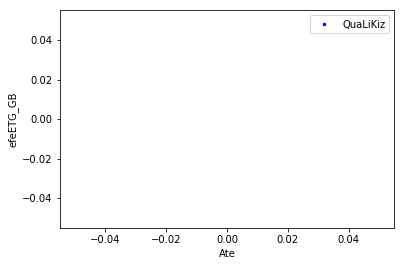

In [53]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

# Add neural network predictions

In [54]:
'''
predictions
'''

'\npredictions\n'

In [55]:
'''
print(type(predictions_nonNormalized))
'''

'\nprint(type(predictions_nonNormalized))\n'

In [56]:
'''
predictions_DF = pandas.DataFrame(predictions_nonNormalized)
'''

'\npredictions_DF = pandas.DataFrame(predictions_nonNormalized)\n'

In [57]:
'''
print(type(predictions_DF))
'''

'\nprint(type(predictions_DF))\n'

In [58]:
'''
predictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))
'''

'\npredictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)\nprint(type(predictions))\n\npredictions = predictions.flatten()\nprint(predictions.shape)\nprint(type(predictions))\n'

In [59]:
'''
print(x_test_np_array_normalized.shape)
'''

'\nprint(x_test_np_array_normalized.shape)\n'

In [60]:
table = numpy.zeros((200,7))

In [61]:
table[:,0] = 5.75    # Ati
table[:,1] = numpy.linspace(2,14,200)   # Ate
table[:,2] = 3       # An
table[:,3] = 3       # qx
table[:,4] = 0.7     # smag
table[:,5] = 0.45    # x
table[:,6] = 1.33    # Ti_Te

In [62]:
table

array([[ 5.75      ,  2.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.06030151,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      ,  2.12060302,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       ...,
       [ 5.75      , 13.87939698,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 13.93969849,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ],
       [ 5.75      , 14.        ,  3.        , ...,  0.7       ,
         0.45      ,  1.33      ]])

In [63]:
# Data Slice values

DataSlice_Ati = 5.75

In [64]:
# Normalize table
table_normalized = numpy.zeros((200,7))

table_normalized[:,0] = DataSlice_Ati * joined_dataFrame_original['Ati'].std()     # Ati

print(table_normalized)
print(table_normalized[:,0])

table_normalized[:,0] = (table_normalized[:,0] * joined_dataFrame_original['Ati'].std()) + joined_dataFrame_original['Ati'].mean()

table_normalized[:,1] = numpy.linspace(2,14,200)   # Ate
table_normalized[:,1] = table_normalized[:,1] * joined_dataFrame_original['Ate'].std()
table_normalized[:,1] = (table_normalized[:,1] * joined_dataFrame_original['Ate'].std()) + joined_dataFrame_original['Ate'].mean()

table_normalized[:,2] = 3 * joined_dataFrame_original['An'].std()      # An
table_normalized[:,2] = (table_normalized[:,2] * joined_dataFrame_original['An'].std()) + joined_dataFrame_original['An'].mean()

table_normalized[:,3] = 3 * joined_dataFrame_original['qx'].std()       # qx
table_normalized[:,3] = (table_normalized[:,3] * joined_dataFrame_original['qx'].std()) + joined_dataFrame_original['qx'].mean()

table_normalized[:,4] = 0.7 * joined_dataFrame_original['smag'].std()     # smag
table_normalized[:,4] = (table_normalized[:,4] * joined_dataFrame_original['smag'].std()) + joined_dataFrame_original['smag'].mean()

table_normalized[:,5] = 0.45 * joined_dataFrame_original['x'].std()    # x
table_normalized[:,5] = (table_normalized[:,5] * joined_dataFrame_original['x'].std()) + joined_dataFrame_original['x'].mean()

table_normalized[:,6] = 1.33 * joined_dataFrame_original['Ti_Te'].std()    # Ti_Te
table_normalized[:,6] = (table_normalized[:,6] * joined_dataFrame_original['Ti_Te'].std()) + joined_dataFrame_original['Ti_Te'].mean()

[[16.92450682  0.          0.         ...  0.          0.
   0.        ]
 [16.92450682  0.          0.         ...  0.          0.
   0.        ]
 [16.92450682  0.          0.         ...  0.          0.
   0.        ]
 ...
 [16.92450682  0.          0.         ...  0.          0.
   0.        ]
 [16.92450682  0.          0.         ...  0.          0.
   0.        ]
 [16.92450682  0.          0.         ...  0.          0.
   0.        ]]
[16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682 16.92450682
 16.92450682 16.92450682 16.92450682 16.92450

In [65]:
print(type(table_normalized))

<class 'numpy.ndarray'>


In [66]:
table_normalized

array([[ 55.25502496,  26.81871226,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367],
       [ 55.25502496,  27.37074163,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367],
       [ 55.25502496,  27.922771  ,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367],
       ...,
       [ 55.25502496, 135.56849825,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367],
       [ 55.25502496, 136.12052762,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367],
       [ 55.25502496, 136.67255699,  10.67975572, ...,   1.40242457,
          0.52085684,   1.98152367]])

In [67]:
table_normalized[:,0]

array([55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25502496,
       55.25502496, 55.25502496, 55.25502496, 55.25502496, 55.25

In [68]:
joined_dataFrame_original['Ati'].std()

2.9433924905350737

In [69]:
joined_dataFrame

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
978721,-1.062802,-1.848058,-1.903644,-0.634902,-0.793142,-0.055552,1.243397,1.665897
981745,-1.099909,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.243397,1.665897
981787,-1.036617,-1.848058,-1.903644,-0.634902,-0.674946,-0.314697,1.767242,1.665897
985063,-1.115442,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,0.719553,1.665897
985105,-1.046617,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,1.243397,1.665897
985147,-1.014513,-1.848058,-1.903644,-0.634902,-0.556750,-0.314697,1.767242,1.665897
988423,-1.096068,-1.848058,-1.903644,-0.634902,-0.438554,-0.314697,0.719553,1.665897
988465,-1.008253,-1.848058,-1.903644,-0.634902,-0.438554,-0.314697,1.243397,1.665897
988501,-1.112594,-1.848058,-1.903644,-0.634902,-0.438554,-0.314697,1.767242,0.421780
988507,-1.017045,-1.848058,-1.903644,-0.634902,-0.438554,-0.314697,1.767242,1.665897


In [70]:
new_predictions = new_model.predict(table_normalized, batch_size = 10, verbose=0)
print(type(new_predictions))
new_predictions = new_predictions.flatten()

<class 'numpy.ndarray'>


In [71]:
print(new_predictions.shape)

(200,)


In [72]:
new_predictions.max()

1.2627052

In [73]:
print(new_predictions)

[0.9652501  0.9602149  0.96195775 1.1041017  1.1954495  1.1633986
 1.2627052  1.0621322  0.4907206  0.27981797 0.21927759 0.19586426
 0.18526578 0.18013805 0.1775834  0.17629334 0.1756371  0.17530197
 0.17513034 0.17504251 0.17499685 0.17497292 0.1749602  0.17495361
 0.17494881 0.17494535 0.17494169 0.17493671 0.17492875 0.17491624
 0.17489609 0.17486942 0.17485347 0.1749332  0.17543864 0.17748424
 0.18450463 0.20622584 0.26685324 0.39348897 0.54246485 0.70096666
 0.8311059  0.90947086 0.95206326 0.974829   0.98700374 0.99352723
 0.9970271  0.9989063  0.99991566 1.0004576  1.0007496  1.0009062
 1.0009902  1.0010358  1.00106    1.0010731  1.0010806  1.0010847
 1.001087   1.0010878  1.0010889  1.001089   1.0010899  1.0010897
 1.0010902  1.0010905  1.0010908  1.0010909  1.0010912  1.0010912
 1.0010914  1.0010916  1.0010922  1.0010923  1.0010924  1.0010929
 1.0010927  1.0010934  1.0010931  1.0010933  1.0010937  1.0010946
 1.0010945  1.0010947  1.0010946  1.0010954  1.0010958  1.0010958
 1.

(array([ 30.,   0.,   2.,   1.,   1.,   0.,   2., 159.,   2.,   3.]),
 array([0.17485347, 0.28363865, 0.39242382, 0.50120899, 0.60999417,
        0.71877934, 0.82756451, 0.93634969, 1.04513486, 1.15392003,
        1.26270521]),
 <a list of 10 Patch objects>)

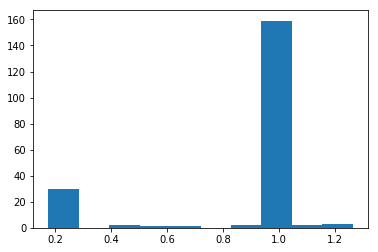

In [74]:
import matplotlib.pyplot as plt
plt.hist(new_predictions)

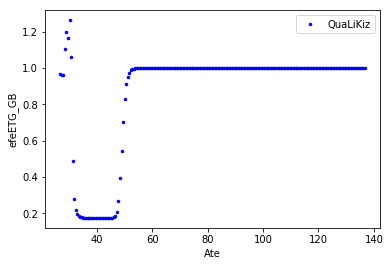

In [75]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table_normalized[:,1], new_predictions, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [76]:
new_predictions_normalized = new_model.predict(table_normalized, batch_size = 10, verbose=0)

In [77]:
new_predictions_normalized.max()

1.2627052

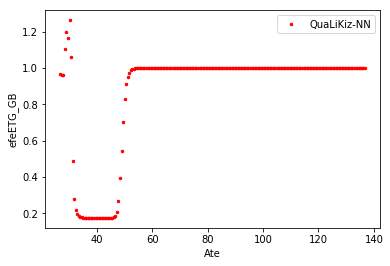

In [78]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_normalized[:,1], new_predictions_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [79]:
# De-Normalizes the neural network predictions
new_predictions_de_normalized = new_predictions_normalized*116.856499    # table.max().astype(numpy.float64)
print(new_predictions_de_normalized.max())

147.55531


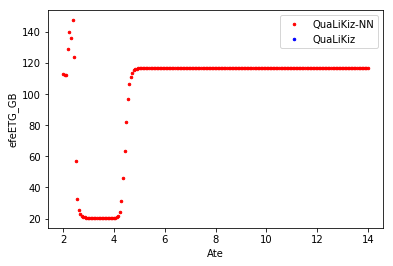

In [80]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_de_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

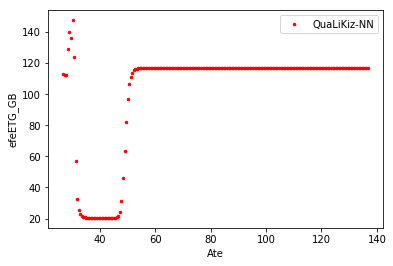

In [81]:
# EXPERIMENTAL: Visualizing Normalized predicted data
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table_normalized[:,1], new_predictions_de_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
#plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [82]:
60/0.15

400.0

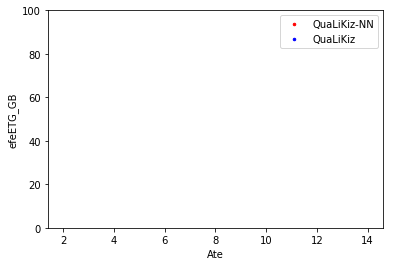

In [83]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_de_normalized*116.856499, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.ylim(0, 100)
plt.legend()
plt.show()

In [84]:
# Normalizes data (no standardization necessary due to dataset design)
table_normalized_MinMax = table/table.max().astype(numpy.float64)

In [87]:
new_predictions_normalized_MinMax = new_model.predict(table_normalized_MinMax, batch_size = 10, verbose=0)

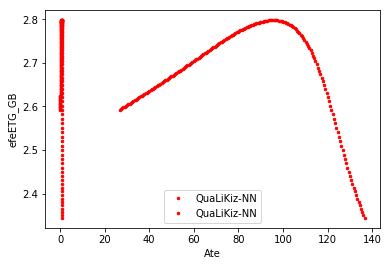

In [90]:
# efeETG_DF = newDF['efeETG_GB']
# Ate_DF = newDF['Ate']
plt.plot(table_normalized_MinMax[:,1], new_predictions_normalized_MinMax, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(table_normalized[:,1], new_predictions_normalized_MinMax, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()